In [19]:
import torch 

import random

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from torch.utils.data import DataLoader


1. Set up CIFAR-10 Datasets and Loaders

In [20]:
# Data transformations (Normalization is important)

transform = transforms.Compose([

    transforms.ToTensor(),

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Mean and std deviation for 3 channels
])

# Load the CIFAR-10 Dataset

train_dataset = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)

test_dataset = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)

# Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [21]:
class CustomNN(nn.Module):

    def __init__(self):
        super(CustomNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2,2)


        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128  * 8 * 8 , 256)

        self.fc2 = nn.Linear( 256 , 10) # CIFAR-10 has 10 classes


    def forward(self,x):

        x = F.relu(self.conv1(x))

        x = self.pool(F.relu(self.conv2(x)))

        x = self.pool(F.relu(self.conv3(x)))


        x = x.view(x.size(0), -1) # Flatten

        x = F.relu(self.fc1(x))

        x = self.fc2(x)

        return x

Create Model Instance and Set Device(MPS FOR MAC)

In [22]:
# Use MPS if available (for Apple Silicon Macbook)

device  = torch.device("mps" if torch.backends.mps.is_available() else 'cpu')

print(f'Using Device :{device}')

model = CustomNN().to(device)

Using Device :mps


Set loss function and optimizer

In [23]:
# Loss and  optimizer

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr=0.001)

Train for 10 epochs increase it later

In [24]:
num_epochs = 10


train_losses = []

test_losses = []

train_accuracies = []

test_accuracies = []


for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0

    correct = 0

    total = 0


    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()


        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()


        running_loss += loss.item()

        _, predicted = outputs.max(1)

        total += labels.size(0)

        correct += predicted.eq(labels).sum().item()



    train_loss = running_loss / len(train_loader)

    train_acc = 100. * correct / total

    train_losses.append(train_loss)

    train_accuracies.append(train_acc)


    # Evaluation phase

    model.eval()

    test_loss = 0.0

    correct = 0

    total = 0


    with torch.no_grad():

        for input, labels in test_loader:

            input, labels = input.to(device), labels.to(device)


            outputs = model(input)

            loss = criterion(outputs, labels)


            test_loss += loss.item()

            _, predicted = outputs.max(1)

            total += labels.size(0)

            correct += predicted.eq(labels).sum().item()

    
    test_loss /= len(test_loader)

    test_acc = 100. * correct / total

    test_losses.append(test_loss)

    test_accuracies.append(test_acc)

    print(f'Epoch [{epoch + 1}/{num_epochs}] -> Train Loss : {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% ')

Epoch [1/10] -> Train Loss : 1.2351, Train Acc: 55.67%, Test Loss: 0.9296, Test Acc: 66.93% 
Epoch [2/10] -> Train Loss : 0.7821, Train Acc: 72.27%, Test Loss: 0.7882, Test Acc: 72.89% 
Epoch [3/10] -> Train Loss : 0.5733, Train Acc: 79.96%, Test Loss: 0.7110, Test Acc: 75.97% 
Epoch [4/10] -> Train Loss : 0.3924, Train Acc: 86.16%, Test Loss: 0.7423, Test Acc: 75.43% 
Epoch [5/10] -> Train Loss : 0.2335, Train Acc: 91.93%, Test Loss: 0.9113, Test Acc: 76.16% 
Epoch [6/10] -> Train Loss : 0.1391, Train Acc: 95.17%, Test Loss: 1.0773, Test Acc: 74.55% 
Epoch [7/10] -> Train Loss : 0.0951, Train Acc: 96.78%, Test Loss: 1.2018, Test Acc: 73.77% 
Epoch [8/10] -> Train Loss : 0.0690, Train Acc: 97.63%, Test Loss: 1.3749, Test Acc: 75.19% 
Epoch [9/10] -> Train Loss : 0.0694, Train Acc: 97.64%, Test Loss: 1.4691, Test Acc: 74.62% 
Epoch [10/10] -> Train Loss : 0.0695, Train Acc: 97.62%, Test Loss: 1.3574, Test Acc: 75.10% 


Plot loss and accuracy curves

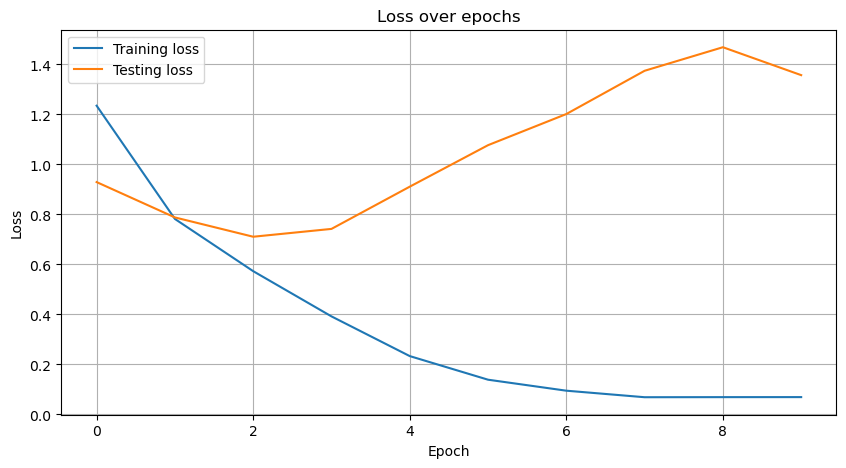

In [25]:
# Plotting loss

plt.figure(figsize=(10,5))

plt.plot(train_losses, label= 'Training loss')

plt.plot(test_losses, label= 'Testing loss')

plt.title('Loss over epochs')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

plt.grid(True)

plt.show()

Plot Training and testing accuracy curves

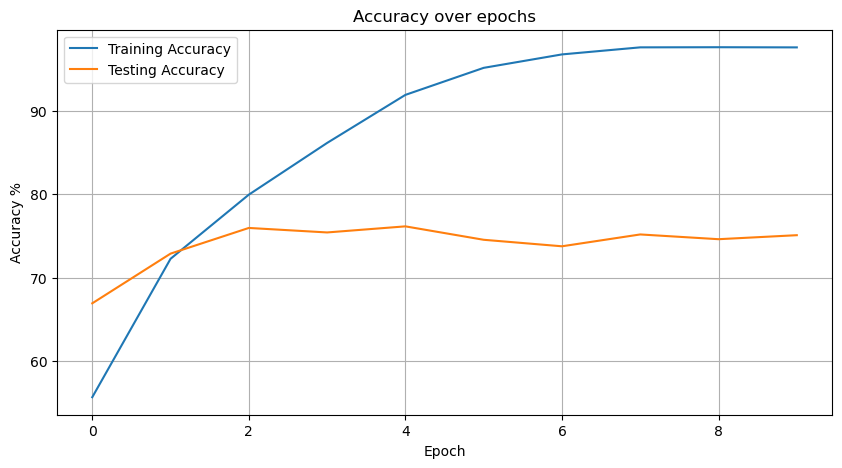

In [26]:
# Plotting loss

plt.figure(figsize=(10,5))

plt.plot(train_accuracies, label= 'Training Accuracy')

plt.plot(test_accuracies, label= 'Testing Accuracy')

plt.title('Accuracy over epochs')

plt.xlabel('Epoch')

plt.ylabel('Accuracy %')

plt.legend()

plt.grid(True)

plt.show()

Prediction on Random Test Images

In [27]:
# Define a function to display predictions

def show_predictions(model, test_loader,device, classes, num_images=5):

    model.eval()

    images_shown = 0

    plt.figure(figsize=(15,6))


    with torch.no_grad():

        for images, labels in test_loader:

            images, labels = images.to(device), labels.to(device)

            